# 2. Constraints, Penalty Terms and Transformations
## Overview

In this tutorial notebook, we will explore the QCE Session Chair Assignment Problem. This is a constrained optimization problem that first needs to be reformulated into an unconstrained format in order to be solved with QAOA. To this end we will get in touch with the `transformations` feature of AqModels, which allows you to construct specific, generalized pipelines for optimization model transformation.



In [1]:
import itertools

import matplotlib.pyplot as plt

# Optimization modeling library
from luna_quantum import Comparator, Model, Solution, quicksum

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.visualization import plot_floor_plan, plot_satisfaction

# Import utils
from utils import optimize_and_plot, pretty

# Classical optimization

## The QCE Session Chair Assignment Problem

We have the following scenario: This year, Quantum Week is unfortunately massively understaffed, meaning that there are more sessions held in parallel than the number of people who can chair each of the sessions. This means that a single person has to chair multiple sessions simultaneously. To this end, we are posed with the challenge of finding an assignment that causes the least inconvenience to all of the available personnel.

The inconvenience per person is calculated by:
- The **walking distance** between all the rooms he is assigned to, the more rooms, the more walking anyone has to do. This distance is weighted by a **fitness** factor (between 1 and 3, where 3 means most fit).
- Minus the satisfaction of chairing sessions, the person is actually interested in.

Below, you can see part of the Albuquerque convention center that is of our interest.
The five rooms marked in blue are the ones where a session is about to be held. Additionally, there are three chairs with varying fitness levels and different favourite sessions.

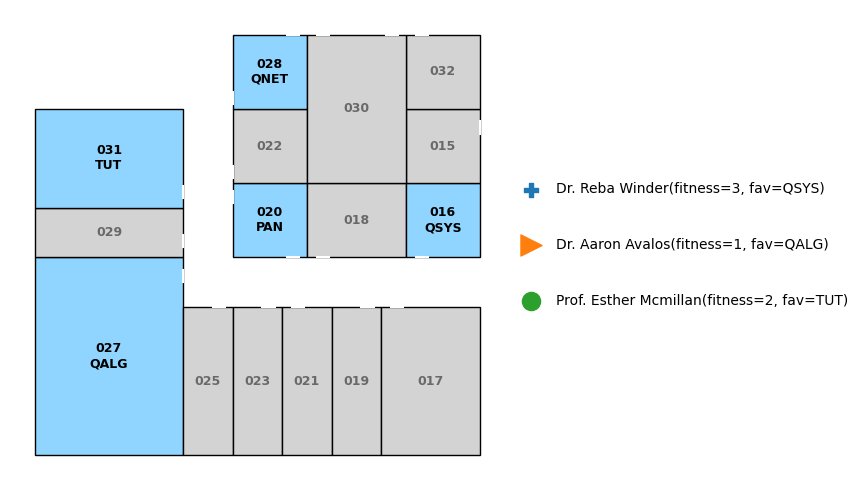

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

fig, ax = plot_floor_plan(center, schedule=schedule, chairs=chairs)
plt.savefig("../sca.pdf", bbox_inches="tight")

### Mathematical Formulation

Mathematically, we can define the optimization problem through a binary variable per room $r$ and person $i$, namely $x_{r,i}\in\{0,1\}$. The distances between the rooms is given by $d_{r,r'}$, the fitness $f_i \in [1, 3]$ and the satisfaction score $s$. Together, the objective quantifying the inconvenience is the following

$$ \begin{align}
\underset{x}{\mathrm{argmin}}& \sum_{i\in C} (4-f_i) \sum_{r > r' \in R} d_{r,r'} x_{r, i} x_{r', i} - s \sum_{i \in C} \sum_{r \in R_i} x_{r, i}\\
\text{s.t.} & \sum_{i \in C} x_{r, i} = 1 \quad \forall r \in R
\end{align} $$

The **one-hot constraint** ensures that each room has exactly one person assigned to it.

### Modelling

Given the mathematical formulation, we can now model the problem in code using our modelling framework.

In [3]:
# Initialize minimization model
model = Model("Session chair assignment")

# Add binary variables to the optimization model
x = {}
for r in schedule.rooms():
    for i in range(len(chairs)):
        # If no vtype is specified, binary vtype is selected by default
        x[r, i] = model.add_variable(f"x_{r}_{i}")

# Objective function part 1: Minimize total distance to travel for every session chair
# Hint: `model.objective += expr`
distance = center.distance_map
##TASK>
model.objective += quicksum(
    round((4 - chair.fitness) * distance[room_a, room_b], 1)
    * x[room_a, i]
    * x[room_b, i]
    for i, chair in enumerate(chairs)
    for room_a, room_b in itertools.combinations(schedule.rooms(), r=2)
)
##<TASKEND

# Objective function part 2: Maximize satisfaction for chairing favorite sessions
session_to_room_map = {v: k for k, v in schedule.items()}
model.objective -= quicksum(
    satisfaction * x[session_to_room_map[chair.favorite], i]
    for i, chair in enumerate(chairs)
)


# one-hot constraints: Every room needs to have exactly one chair
# Hint: `model.add_constriant(expr == 1, name)`
for room in schedule.rooms():
    constraint_name = f"someone_in_{room}"
    ##TASK>
    model.add_constraint(
        quicksum(x[room, i] for i in range(len(chairs))) == 1, constraint_name
    )
    ##<TASKEND

print(model)

Model: Session chair assignment
Minimize
  7.5 * x_016_0 * x_028_0 + 4 * x_016_0 * x_020_0 + 5 * x_016_0 * x_031_0 
  + 4.8 * x_016_0 * x_027_0 + 22.5 * x_016_1 * x_028_1 + 12 * x_016_1 * x_020_1 
  + 15 * x_016_1 * x_031_1 + 14.4 * x_016_1 * x_027_1 + 15 * x_016_2 * x_028_2 
  + 8 * x_016_2 * x_020_2 + 10 * x_016_2 * x_031_2 + 9.6 * x_016_2 * x_027_2 
  + 3.5 * x_028_0 * x_020_0 + 3.9 * x_028_0 * x_031_0 + 5.4 * x_028_0 * x_027_0 
  + 10.5 * x_028_1 * x_020_1 + 11.7 * x_028_1 * x_031_1 
  + 16.2 * x_028_1 * x_027_1 + 7 * x_028_2 * x_020_2 + 7.8 * x_028_2 * x_031_2 
  + 10.8 * x_028_2 * x_027_2 + x_020_0 * x_031_0 + 1.9 * x_020_0 * x_027_0 
  + 3 * x_020_1 * x_031_1 + 5.7 * x_020_1 * x_027_1 + 2 * x_020_2 * x_031_2 
  + 3.8 * x_020_2 * x_027_2 + 1.7 * x_031_0 * x_027_0 + 5.1 * x_031_1 * x_027_1 
  + 3.4 * x_031_2 * x_027_2 - 2 * x_016_0 - 2 * x_031_2 - 2 * x_027_1
Subject To
  someone_in_016: x_016_0 + x_016_1 + x_016_2 == 1
  someone_in_028: x_028_0 + x_028_1 + x_028_2 == 1
  someone_

## QUBO Formulation

Unfortunately, QAOA is an optimization algorithm that can only handle binary **unconstrained** optimization problems. _(We will learn alternatives to that shortly.)_ To satisfy this condition, we need to reformulate the equality constraints as quadratic penalties. An expression $(g(x)-c)^2$ is exactly zero iff the constraint $g(x) = c$ is satisfied and greater than zero otherwise. This means if we add this quadratic penalty **alongside a well-chosen penalty factor $\lambda$** to the objective function, the optimum of this, now unconstrained, objective is satisfying the constraint.

In essence, the optimization function is the following, helping us to implement the model:
$$ \begin{align}
\underset{x}{\mathrm{argmin}}& \sum_{i\in C} (4 - f_i)\sum_{r > r' \in R} d_{r,r'} x_{r, i} x_{r', i} - s \sum_{i \in C} \sum_{r \in R_i} x_{r, i} + \lambda \sum_{r \in R} \left(1 - \sum_{i \in C} x_{r, i}\right)^2
\end{align} $$

In [4]:
# Initialize minimization model
model2 = Model("Session chair assignment (penalty)")

# Add binary variables to the optimization model
x2 = {}
for r in schedule.rooms():
    for i in range(len(chairs)):
        # If no vtype is specified, binary vtype is selected by default
        x2[r, i] = model2.add_variable(f"x_{r}_{i}")

# Objective function part 1: Minimize total distance to travel for every session chair
distance = center.distance_map
model2.objective += quicksum(
    round((4 - chair.fitness) * distance[room_a, room_b], 1)
    * x2[room_a, i]
    * x2[room_b, i]
    for i, chair in enumerate(chairs)
    for room_a, room_b in itertools.combinations(schedule.rooms(), r=2)
)

# Objective function part 2: Maximize satisfaction for chairing favorite sessions
session_to_room_map = {v: k for k, v in schedule.items()}
model2.objective -= quicksum(
    satisfaction * x2[session_to_room_map[chair.favorite], i]
    for i, chair in enumerate(chairs)
)

# EVERYTHING IS THE SAME UNTIL HERE

penalty = 50

# one-hot constraints: Every room needs to have exactly one chair
# Now as quadratic penalty
for room in schedule.rooms():
    ##TASK>
    model2.objective += (
        penalty * (quicksum(x2[room, i] for i in range(len(chairs))) - 1) ** 2
    )
    ##<TASKEND

print(model2)

Model: Session chair assignment (penalty)
Minimize
  100 * x_016_0 * x_016_1 + 100 * x_016_0 * x_016_2 + 7.5 * x_016_0 * x_028_0 
  + 4 * x_016_0 * x_020_0 + 5 * x_016_0 * x_031_0 + 4.8 * x_016_0 * x_027_0 
  + 100 * x_016_1 * x_016_2 + 22.5 * x_016_1 * x_028_1 + 12 * x_016_1 * x_020_1 
  + 15 * x_016_1 * x_031_1 + 14.4 * x_016_1 * x_027_1 + 15 * x_016_2 * x_028_2 
  + 8 * x_016_2 * x_020_2 + 10 * x_016_2 * x_031_2 + 9.6 * x_016_2 * x_027_2 
  + 100 * x_028_0 * x_028_1 + 100 * x_028_0 * x_028_2 + 3.5 * x_028_0 * x_020_0 
  + 3.9 * x_028_0 * x_031_0 + 5.4 * x_028_0 * x_027_0 + 100 * x_028_1 * x_028_2 
  + 10.5 * x_028_1 * x_020_1 + 11.7 * x_028_1 * x_031_1 
  + 16.2 * x_028_1 * x_027_1 + 7 * x_028_2 * x_020_2 + 7.8 * x_028_2 * x_031_2 
  + 10.8 * x_028_2 * x_027_2 + 100 * x_020_0 * x_020_1 + 100 * x_020_0 * x_020_2
  + x_020_0 * x_031_0 + 1.9 * x_020_0 * x_027_0 + 100 * x_020_1 * x_020_2 
  + 3 * x_020_1 * x_031_1 + 5.7 * x_020_1 * x_027_1 + 2 * x_020_2 * x_031_2 
  + 3.8 * x_020_2 * x_

Great, this now means, we can use the `qaoa_circ` method from last notebook to generate the circuit. We provide the `qaoa_circ` together with the other methods in the `utils` module.

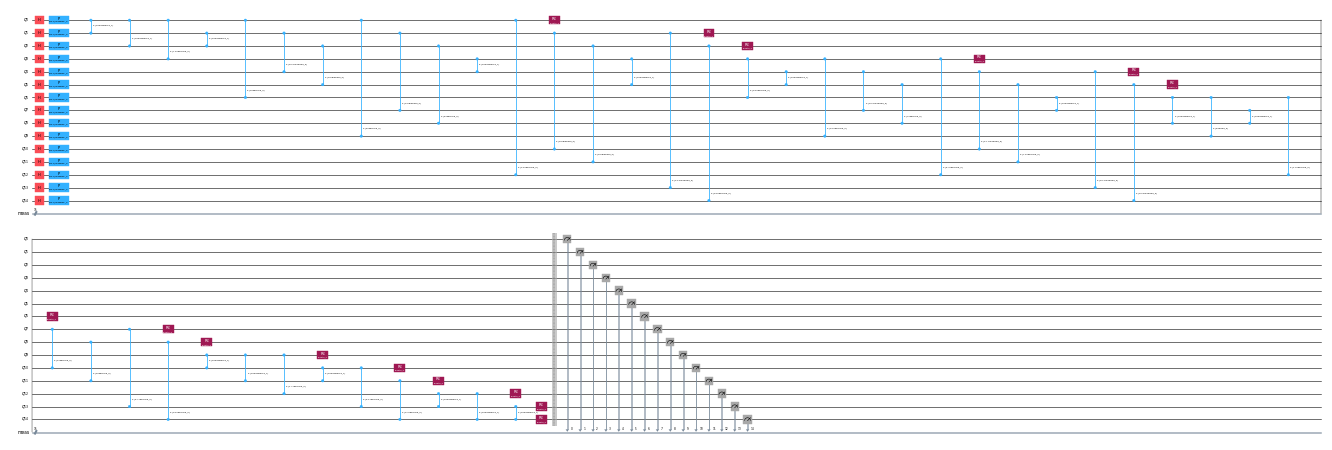

In [5]:
from utils.qaoa import qaoa_circ

qaoa_circ(model2).draw("mpl", scale=0.2, fold=100)

---
## Enter Transformations - An Automatic Approach to Constraint Reformulations

Instead of manually transforming all of the models separately, let us build a pipeline that transforms an optimization problem into a format that the QAOA circuit generator can understand. For this purpose, AqModels has an integrated "transformations" feature. This feature borrows its architecture from common compiler design, like it is known from LLVM or Qiskit. This means, we define a `PassManager` that applies `Pass`es to the optimization model. Each pass can either be `TransformationPass` or an `AnalysisPass`. The `AnalysisPass` does not alter the model but only performs analysis on the contents, while the `TransformationPass` applies modifications to the model.

After running a `PassManager` on a model, we receive an object which we call `IntermediateRepresentation`, which contains the model plus additional metadata necessary to generate the circuit.

<img src="../assets/pass_manager.png" width=800px />

In [6]:
# Transformations imports
from luna_quantum.transformations import (
    ActionType,
    AnalysisCache,
    MaxBiasAnalysis,
    PassManager,
    TransformationPass,
    TransformationOutcome,
)

Before building oursevels a new transformation pass turning equality constraints to quadratic penalties, we take a look at a small, pre-defined analysis pass. Namely, the `MaxBiasAnalysis`, which finds the maximum absolute coefficient in the model. This is very useful for us, since we need to also automatically determine the penalty coefficient $\lambda$. A common heuristic for that is to take a mutliple of the maximal bias.

In [7]:
# Define the PassManager
pass_manager = PassManager([MaxBiasAnalysis()])
print(pass_manager)

PassManager
🔎 max-bias


In [8]:
# Run and print the result
print(pass_manager.run(model).cache)

 max-bias: MaxBias(val=22.5)


### Our Own Transformation Pass for Quadratic Penalties

Next step is to construct our own transformation pass. Simply inherit from the `TransformationPass` class and implement the necessary methods that are
- `name`: unique identifier of this pass
- `requires`: the passes listed here must be run before this pass
- `run`: run the pass
- `backwards`: Backtransform the solution if necessary

Now, finish the implementation of the `QuadraticPenaltyPass` that transforms **every equality constraint** into a quadratic penalty.

In [9]:
class QuadraticPenaltyPass(TransformationPass):
    """Integrates equality constraints as quadratic penalties."""

    def __init__(self, penalty_multiplier: float = 5.0):
        self.penalty_multiplier = penalty_multiplier

    @property
    def name(self):
        return "quadratic-penalty"

    @property
    def requires(self):
        return ["max-bias"]

    @property
    def invalidates(self):
        return ["max-bias"]

    def run(self, model: Model, cache: AnalysisCache):
        max_bias = cache["max-bias"]

        # Eval the penalty from the scaling factor and max bias
        penalty = self.penalty_multiplier * max_bias.val

        # Keep track of what constraints need to be removed. Use indices.
        to_remove: list[int] = []

        # Hints:
        # - You can iterate over `model.constraints`
        # - You can check the constraint type by `constraint.comparator == Comparator.{Le, Eq, Ge}`
        ##TASK>
        for i, c in enumerate(model.constraints):
            # Only handle equality constraints
            if c.comparator != Comparator.Eq:
                continue
            # Remove this constraint
            to_remove.append(i)

            # Add the quadratic penalty to the objective
            model.objective += penalty * (c.lhs - c.rhs) ** 2
        ##<TASKEND

        if len(to_remove) == 0:
            return TransformationOutcome.nothing(model)

        for r in reversed(to_remove):
            model.constraints.remove(r)

        return model, ActionType.DidTransform

    # Backwards function needs to be implemented.
    # Performs the inverse transformation of the solution if necessary
    # Here it can just be the identity
    def backwards(self, solution: Solution, cache: AnalysisCache):
        return solution

### Let's See it in Practice

The `QuadraticPenaltyPass` can now be used in the pass manager likewise to the other passes

In [10]:
# Define a PassManager with the `penalty_multiplier=2`
##TASK>
pass_manager = PassManager(
    [MaxBiasAnalysis(), QuadraticPenaltyPass(penalty_multiplier=2)]
)
##<TASKEND

ir = pass_manager.run(model)

# Ignore for now, will become important later
scale = 1.0

print(ir.model)

Model: Session chair assignment
Minimize
  90 * x_016_0 * x_016_1 + 90 * x_016_0 * x_016_2 + 7.5 * x_016_0 * x_028_0 
  + 4 * x_016_0 * x_020_0 + 5 * x_016_0 * x_031_0 + 4.8 * x_016_0 * x_027_0 
  + 90 * x_016_1 * x_016_2 + 22.5 * x_016_1 * x_028_1 + 12 * x_016_1 * x_020_1 
  + 15 * x_016_1 * x_031_1 + 14.4 * x_016_1 * x_027_1 + 15 * x_016_2 * x_028_2 
  + 8 * x_016_2 * x_020_2 + 10 * x_016_2 * x_031_2 + 9.6 * x_016_2 * x_027_2 
  + 90 * x_028_0 * x_028_1 + 90 * x_028_0 * x_028_2 + 3.5 * x_028_0 * x_020_0 
  + 3.9 * x_028_0 * x_031_0 + 5.4 * x_028_0 * x_027_0 + 90 * x_028_1 * x_028_2 
  + 10.5 * x_028_1 * x_020_1 + 11.7 * x_028_1 * x_031_1 
  + 16.2 * x_028_1 * x_027_1 + 7 * x_028_2 * x_020_2 + 7.8 * x_028_2 * x_031_2 
  + 10.8 * x_028_2 * x_027_2 + 90 * x_020_0 * x_020_1 + 90 * x_020_0 * x_020_2 
  + x_020_0 * x_031_0 + 1.9 * x_020_0 * x_027_0 + 90 * x_020_1 * x_020_2 
  + 3 * x_020_1 * x_031_1 + 5.7 * x_020_1 * x_027_1 + 2 * x_020_2 * x_031_2 
  + 3.8 * x_020_2 * x_027_2 + 90 * x_031

=== Running optimization for p=1 layers ===
Circuit depth: 23, Parameters: 2
Iteration 5: Energy = 295.980
Iteration 10: Energy = 137.753
Iteration 15: Energy = 136.320
-------------------------
Energy: 136.320
Best objective value: 4.900

=== Running optimization for p=2 layers ===
Circuit depth: 32, Parameters: 4
Iteration 5: Energy = 278.708
Iteration 10: Energy = 196.005
Iteration 15: Energy = 193.171
Iteration 20: Energy = 192.881
-------------------------
Energy: 191.968
Best objective value: 13.700

=== Running optimization for p=3 layers ===
Circuit depth: 47, Parameters: 6
Iteration 5: Energy = 275.776
Iteration 10: Energy = 274.039
Iteration 15: Energy = 268.810
Iteration 20: Energy = 268.130
-------------------------
Energy: 268.130
Best objective value: 6.400

=== Running optimization for p=4 layers ===
Circuit depth: 56, Parameters: 8
Iteration 5: Energy = 260.805
Iteration 10: Energy = 242.672
Iteration 15: Energy = 238.250
Iteration 20: Energy = 238.421
Iteration 25: Ene

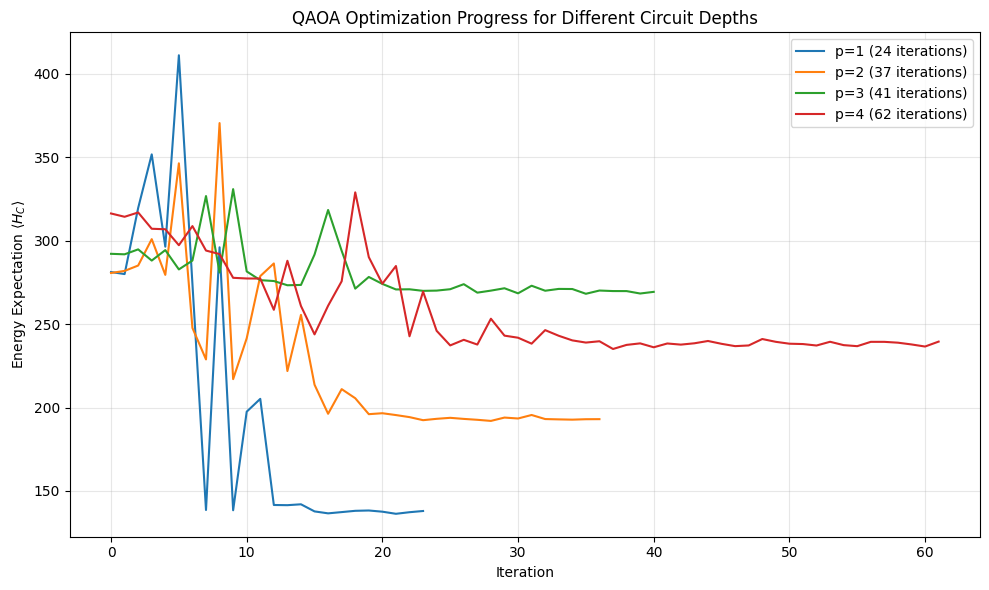

In [11]:
def circuit(p: int):
    return qaoa_circ(ir.model, p, scale=scale)


final_solution, best = optimize_and_plot(circuit, ir.model, range(1, 5), shots=10000)

**Not really great optimization right? Why aren't we getting better results, especially when the number of layers increases?**

The main explanation is the magnitude of the coefficients in the problem. With MaxCut, we only really have small integer coefficients. Here, our coefficients, especially with penalty terms, are significantly larger. As a consequence, a moderate gamma value of 0.5 would already overrotate the phase angle. Therefore, it is good practice to normalize the Hamiltonian before applying the phase. One common method is to divide by the maximum bias in the Hamiltonian.

For this, we need to generate a new pipeline that re-evaluates the maximum bias and scales by one over the maximum bias.

In [12]:
# Define a PassManager with the `penalty_multiplier=2`
##TASK>
pass_manager = PassManager(
    [MaxBiasAnalysis(), QuadraticPenaltyPass(penalty_multiplier=2), MaxBiasAnalysis()]
)
##<TASKEND

ir = pass_manager.run(model)

# Ignore for now, will become important later
scale = 2.0 / ir.cache["max-bias"].val

=== Running optimization for p=1 layers ===
Circuit depth: 23, Parameters: 2
Iteration 5: Energy = 113.317
Iteration 10: Energy = 94.019
Iteration 15: Energy = 94.703
Iteration 20: Energy = 94.615
-------------------------
Energy: 92.288
Best objective value: 4.600

=== Running optimization for p=2 layers ===
Circuit depth: 32, Parameters: 4
Iteration 5: Energy = 68.662
Iteration 10: Energy = 69.901
Iteration 15: Energy = 71.639
Iteration 20: Energy = 68.780
-------------------------
Energy: 65.363
Best objective value: 2.800

=== Running optimization for p=3 layers ===
Circuit depth: 47, Parameters: 6
Iteration 5: Energy = 68.256
Iteration 10: Energy = 66.689
Iteration 15: Energy = 68.804
Iteration 20: Energy = 70.013
-------------------------
Energy: 64.050
Best objective value: 2.800

=== Running optimization for p=4 layers ===
Circuit depth: 56, Parameters: 8
Iteration 5: Energy = 63.147
Iteration 10: Energy = 66.624
Iteration 15: Energy = 61.482
Iteration 20: Energy = 64.670
Itera

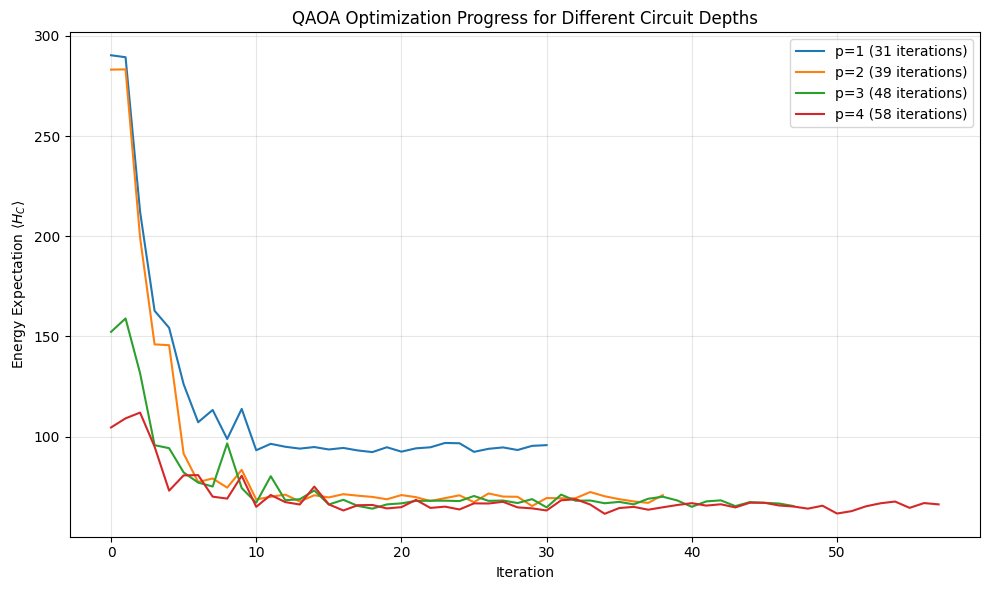

In [13]:
def circuit(p: int):
    return qaoa_circ(ir.model, p, scale=scale)


final_solution, best = optimize_and_plot(circuit, ir.model, range(1, 5))

Investigating the full set of samples in the solution reveals their distribution

In [14]:
pretty(final_solution)

x_016_0,x_016_1,x_016_2,x_028_0,x_028_1,x_028_2,x_020_0,x_020_1,x_020_2,x_031_0,x_031_1,...
1,0,0,0,1,0,1,0,0,0,0,
1,0,0,1,0,0,0,0,1,0,0,
0,0,1,0,1,0,1,0,0,1,0,
0,1,0,1,0,0,1,0,0,0,0,
1,0,0,0,0,1,1,0,0,0,1,
1,0,0,0,1,0,0,0,1,0,0,
1,0,0,0,0,1,1,0,0,0,0,
1,0,0,0,0,1,0,1,0,0,1,
1,0,0,0,0,1,1,0,0,1,0,
0,0,1,1,0,0,1,0,0,0,1,


Since the transformed model is unconstrained, the feasibility ration is 100%. Backtransformation reintroduces the constraints. Thus we get the real feasiblity ratio:

In [15]:
print(
    f"Final Solution Feasibiltiy Ratio: {100 * final_solution.feasibility_ratio():.1f}%"
)
solution = pass_manager.backwards(final_solution, ir)
print(
    f"Backtransformed Solution Feasibiltiy Ratio: {100 * solution.feasibility_ratio():.1f}%"
)

Final Solution Feasibiltiy Ratio: 100.0%
Backtransformed Solution Feasibiltiy Ratio: 33.1%


### Visualization of the Best Result

Let's put the chairs in their assigned rooms

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

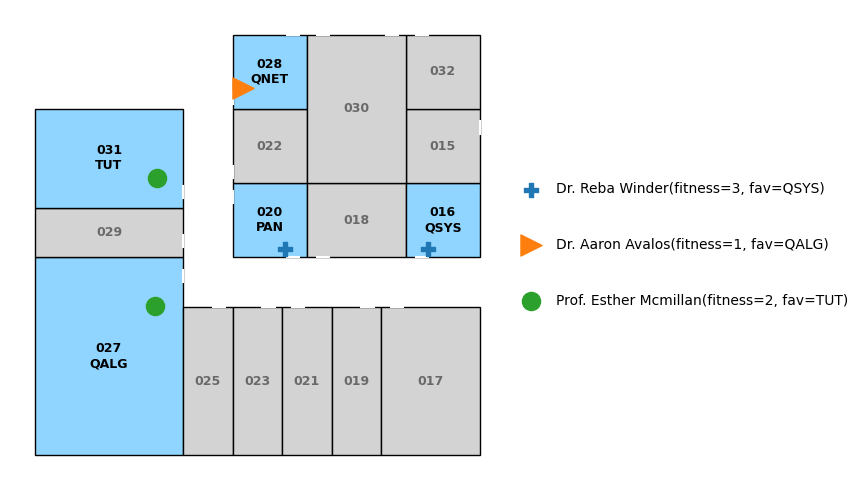

In [16]:
assignment = [
    (chair.name, room)
    for i, chair in enumerate(chairs)
    for room in schedule.rooms()
    if best.sample[x[room, i]]
]
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

(<Figure size 300x300 with 1 Axes>, <Axes: ylabel='Satisfaction'>)

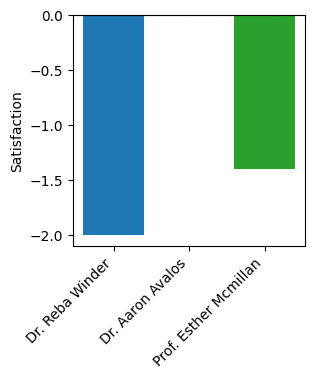

In [17]:
# We can plot the satisfaction per person. Ideally this is high for everyone.
plot_satisfaction(center, schedule, chairs, assignment)

---

## 🎉 Congratulations!

You've successfully completed this tutorial! We hope you found it helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- A. Lucas, 2014: Ising Formulations [[Paper]](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full)

### 🚀 Coming Up Next

In the [next tutorial](03_XYMixers.ipynb), we will explore how one-hot constraints can be handled with **XY-Mixers** to increase performance.

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>